# Homework - Categorization and Model Comparison Part A (70/110 points)

by *Todd Gureckis* and *Brenden Lake*  
Computational Cognitive Modeling  
NYU class webpage: https://brendenlake.github.io/CCM-site/  

<div class="alert alert-danger" role="alert">
  This homework is due before midnight on April 25 2022. 
</div>

---

In [1]:
import string as str
import os
import numpy as np
import seaborn as sns
import pandas as pd
import math
from random import random, randint, shuffle, uniform
from scipy.optimize import fmin, brute

# Background and Theory

In this homework we explore the cognitive mechanisms that support unsupervised pattern categorization in humans.  In addition, we use this as an example of testing and comparing between models.

## A simple (classic) unsupervised categorization experiment

In Posner and Keele (1968) report a now classic categorization experiment with humans.  In the task participants viewed visual stimuli that are clouds of points (known as dot patterns) similar to a scatter plot of data on a graph.  An examples of the stimuli is shown here:

<img src='images/singledotpattern.png'>

**Experiment Design**  

The experiment was divided into a training and test phase.  During the training phase, for each subject a single random dot pattern was generated and considered to be the underlying "prototype" structure.  A prototype is like a common template or reference pattern.  The key is that participants never get to see the "prototype" pattern directly during training.  Instead they see what are known as "distortions" of the prototype.  A distortion of a pattern is made by adding random spatial noise to each point in a pattern to kind of "wiggle" the points away from their original position.  

For example, here is a random prototype (top) and a bunch of random distortions of the prototype made by adding or subtracting small random values from the `<x,y>` value of each point in the pattern.

<img src='images/distortions.png'>

Posner and Keele created distortions that added more or less random noise.  For example, "high" distortions add a lot of randomness to the underlying template pattern whereas "low" distortions add only a little bit of noise.

**Training Phase**  

In the training phase of the experiment subjects view 10 training examples one at a time which are "high" distortions of a randomly generated prototype.  The instructions are that subjects should look at these patterns, and that they come from a single category similar to if you viewed a series of pictures of dogs they would all come from the category ``dog``.  Subjects were try to figure out the pattern that related the different images to one another.
Try it for yourself by looking at each of the "distortions" patterns above one by one and trying to detected the common structure.

**Test Phase** 

During the test phase, participants view a series of dot patterns one at a time and have to judge: **Does the given pattern come from the same general category or family you studied earlier or is it a new pattern that is different?**  This is an unsupervised categorization task because the subject has to abstract what the common structure is from the given patterns and then use that information to make classification decisions about new patterns.

Unknown to participants the set of test items varied in a specific way with respect the training patterns.  In particular, there were five particular types of patterns presented during test.

- The first type were "old" patterns which were identical to those presented during the training phase.
- The second type were "random" patterns which were from a complete new randomly generated prototype (thus had nothing to do with the items presented during training).
- The third type were new "high distortions" of the underlying prototype that was used to create the study set.  These are thus similar to the "old" items but do not match exactly.
- The fourth type were "low distortions" of the underlying prototype that was used to crete the study set.  These are more similar to the prototype pattern than the "high" distortions are.
- Finally the actual prototype used to generate the items during training was presented.  This pattern is interesting because the prototype pattern was never seen exactly during training.  However, people saw many high distortions of this item during training and given the instructions to detect what the common structure of the training patterns is, they may have learned something about this latent or hidden pattern.

**Typical Results**:  

This graph show example results that are typical for an experiment like this:

<AxesSubplot:xlabel='Stimulus Type', ylabel='Probability of Endorsement'>

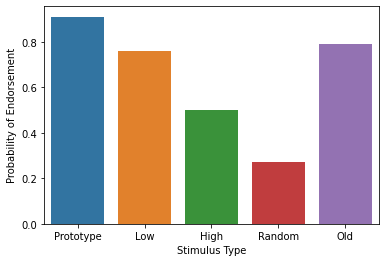

In [2]:
df = pd.DataFrame({"Stimulus Type":['Prototype','Low','High','Random','Old'],"Probability of Endorsement":[0.91,0.76,0.5,0.27,0.79]})
sns.barplot(x="Stimulus Type",y="Probability of Endorsement",data=df)

 The height of the bars indicates the probability of endorsing a pattern as a member of the category during the test phase (high values mean that at test a subject is more likely to agree "yes this pattern fits with the one I learned").  Notice that the "old" items (the exact patterns studied during learning are endorsed at a relatively high rate.  In contrast the "random" patterns (those coming from a completely different underlying pattern) are endorsed at a very low rate.  The low and high distortions are endorsed at intermediate rates (with the low distoritions preferred).  Interestingly, the prototype pattern is endorsed most strongly even though it was never presented during the study period!  It is like during learning people figured out the underlying pattern that generated the stimuli!

## Categorization: Memory for examples or abstractions?

The dot pattern experiments are interesting and have been replicated in various ways perhaps hundreds of time.  How do people make these judgments?  What information to people store during the study phase that would predict their performance in the test phase?  What rule do they use for combining information from memory in order to make these kind of judgements?  We are going to build up a model of categorization in a few simple steps.

## Step 1: How are dot patterns represented in the mind?

Our first question concerns how people represent the dot patterns and the similarity between different dot patterns.  A variety of work has suggested that the psychological similarity between pairs of dot patterns follows roughly a logarithmic transform of the average euclidean distance between the pairs of points (plus one).  This was established by having people view pairs of dot patterns and rate how similar they seem.  For example here is a plot from a paper by Smith and Minda showing a strong contgruence between dissimiliarty ratings between pairs of stimuli and `log(distance)`

<img src="images/dotsimilaritylog.png" width="600">

In light of this lets define the similarity between two dot patterns $i$ and $j$ as $s_{ij}$ and let it equal the following equation:  

<br>
<center>
$\Large s_{ij} = log(1 + \frac{\sqrt{\sum_d[(i_{d_x}-j_{d_x})^2 + (i_{d_y}-j_{d_y})^2]}}{9})$
</center>
<br>

where $i_{d_x}$ is the $x$ position of the $d$-th dot in pattern $i$ and $j_{d_x}$ is the $x$ position for pattern $j$ (likewise for $i_{d_y}$). There are 9 dots total, so we divide by 9 to get the average. Because it can sometimes be ambiguous which dot aligns which which one in a pattern we choose the dots which are closest in the two patterns to compute this score.

## Step 2: What is stored in memory?

The next consideration is what people actually store in memory during the training phase of the experiment.  There are of course many alternatives.  People could store an "average" of the points seen so far, or they could store each individual pattern that they have seen, or they could store nothing and try to figure it out at test, or they could store some verbal description of what the shapes "look like", or the shape of the outer edge of the dot-cloud (the "convex null"), etc...

There are, however, two leading theories which have attracted considerable debate in the cognitive science literature: the prototype and exemplar theory.

### Exemplar models

Exemplar models are a general class of psychological models related to nearest neighbor algorithms.  The most important feature of these models is the idea that people have what appears to be a nearly infitite memory for the past and as a result you can store all past experiences or examples in memory.  This seems crazy as we are forgetting things all the time but actually psychology is unclear about if we actually forget things or if we simply lose the ability to retreive a memory (i.e., more like losing the pointer to the memory rather than decay).  

As mentioned in lecture, nearset neighbor classifiers use a similarity function (similar to the ones described above) to retrieve from memory the nearest labeled example and to predict the category membership based on the label for this item.  This nearest neighbor algorithm can be relaxed slightly to consider $k$-nearest neighbors.  According to this algorithm you find the $k$ neighbor examples (with $k>1$) to the current pattern and response based on what the majority of these examples say.  

Now we can go a bit further and say that you compute the similarity to all past examples but *weight* their vote according to their similarity.  So instead of picking the label of the closest or $k$-closest examples we compare the current pattern using a global match to all examples in the memory and weight their predictions based on similarity.  Pretty neat!

Ok, but how does this help us in the case of **unsupervised** categorization such as in the dot pattern case?  Here what we will assume is that we compute this similarity of the to-be-categorized item (the test item) to all the examples stored in memory and compare it to some criterion value.  If the sum of the similarity to all the examples falls below this criterion then we assume the pattern is new and doesn't match what we learned.  If it is above the criterion we judge the item is a good example of the category.

In the example model we will consider the probability of endorsing an item is going to be determined by the following equation:





<br>
<center>
$\Large P(A|i) = \frac{\sum_j e^{-c \cdot s_{ij}}}{\sum_j e^{-c \cdot s_{ij}} + k}$
</center>
</br>
 

where $P(A|i)$ is the probability of endorsing pattern $i$ as a member of the category seen during study. $s_{ij}$ is the similarity between pattern $i$ and pattern $j$ which is an example stored in memory during the study phase.  $k$ is the criterion against which the summed similarity is being compared.  If $k$ is zero then you endorse the item as a member of the category all the time irrespecitive of the similiary and if $k$ gets large you become more and more less likely to endorse the item (i.e., more likely to say no).

<img src="images/exemplarcompare.png" width="400">

The sum is with respect to an exponential sum which has some deeper relation to research on categorization that we do not have time to discuss.  However, it is basically the idea that very close matches ($s_{ij}=0$) are especially strong and things that are less similar count less.  You can think of it as the the particular weighted nearest neighbor algorithm we think the mind uses. $c$ is a free parameter that controls that weighting function and is often fitted to data.

### Prototype models

The prototype model is different than the exemplar model because it assumes that instead of storing each of the training patterns in memory exactly, instead people store a single summary representation.  For example, people might store a mentally computed "average" pattern.  When you think about how you would perform the task you might think that you kind of compare the training patterns to one another and then compute some summary.

<img src="images/prototypetheory.png" width="500">

In the case of the dot pattern stimuli one way to do this is to store a special trace in memory called the prototype which is the average of all the patterns seen so far (averaging the $<x,y>$ position of each point to find an average dot location.

According to the prototype model the probabililty of endorsing a test item pattern as a member of the category that was studied during training is:

<br>
<center>
$\Large P(A|i) = \frac{e^{-c \cdot s_{ip}}}{e^{-c \cdot s_{ip}} + k}$
</center>
</br>

Note that nearly everything about this equation is the same except there is no longer a sum!  Instead we simply compute the similarity between the test pattern and this special "prototype" pattern ($p$) which has been averaged from the training examples.

<img src="images/prototypecomparison.png" width="500">

### Parameters

$k$ and $c$ are "free parameters" in both the exemplar and prototype model which are assumed to modulate or alter the core psychological processes.  These parameters might vary between subjects and as a function of condition.  Thus, in order to assess the ability of the model to account for the data we often "fit" these parameters to our data.

# Model Comparison

With these idea in mind, in this homework you are going to compare the exemplar and prototype model to account for some data from an actual dot pattern categorization task collected with human subjects.  The goal is that by doing the homework you would develop some useful code that would let you more or less plug in a model that you might come across in your research, fit it to data, and verify that the fits are good, etc...

## Reading in some data

The `data/` folder that comes with this homework contains data from 14 human subjects who participated in a dot pattern classification task.  The data describing each subject is in a text file (`.dat`) indexed by subject number (e.g., `1.dat`, `2.dat`, etc...).

The organization of these files is as follows:

The first 44 lines of the file contain a description of the stimulus that the subject saw on a given trial including the x, y coordinate of each dot.  The first columns of these 44 lines is the number of the pattern (`1-44`).  The second column is the type of pattern using the following codes:

- `1` = prototype
- `2` = 10 "high distortions" of the prototype that were used as study patterns during learning
- `3` = 10 new "high distortions" of the prototype presented during test
- `4` = 4 "low distortions" of the prototype that were presented during test
- `5` = 20 random items that come from different prototypes that were presented at test

The next 18 values of each row are the coordinates of the dots (with the x, y coordinates in sequence).  So `[x1, y1, x2, y2, x3, y3, ...]`.

The following 40 lines of the file show the sequence of items presented during the study phase.  This is not all that important for our purposes, but basically the last column is which pattern was displayed (indexed from the patterns just described.  Each of 10 "high distortions" were presented four times each during study in a random order.

Finally the remaining lines of the file report the results of the test phase.  The first column is the subject number, the second columns is the condition number, the next is the trial number in the experiment, the other columns worth mentioning are the last column (the pattern number from the beginning of the file), the second to last column (the type of stimulus it is according to the codes described above), and the reaction time in milliseconds.

In addition, participants in this experiment were assigned to one of two conditions: a recognition condition and a categorization condition.  These conditions differed only in the instructions given to participants at the start of the test phase.  In the recognition condition participants were told they would view a series of patterns and they should respond "yes" only if the patterns was **exactly** one they say in the previous study phase.  In the categorization condition, participants were asked to respond "yes" only if the pattern belonged to the same general category or pattern that they observed in the training phase.

The following graph computes the probability of endorsement in the data set as a function of stimulus type and condition (Cat or Rec instructions).  

In [3]:
################################
# getcurve
################################
def getcurve(filename):
    prototypes = []
    low = []
    old = []
    high = []
    random = []
    mydata = readfile(filename)
    cond = mydata[-1][1]
    for line in mydata:
        if line[4] == 2 and len(line) == 9:
            if line[7] == 1:
                prototypes.append(line[5])
            if line[7] == 2:
                old.append(line[5])
            if line[7] == 3:
                high.append(line[5])
            if line[7] == 4:
                low.append(line[5])
            if line[7] == 5:
                random.append(line[5])

    #print([len(prototypes), len(low), len(high), len(random), len(old)])
    # print(prototypes)
    # print(low)
    # print(high)
    # print(random)
    # print(old)
    return [np.average(prototypes), np.average(low), np.average(high), np.average(random), np.average(old), filename, cond]


def readfile(filename):
    results = []
    fp = open(filename, 'r')
    for line in fp.readlines():
        myline = list(map(int, line.split(' ')[:-1]))
        results.append(myline[:])
    fp.close()
    return results


def get_all_filenames(directoryname):
    files = filter(lambda x: x[-4:] == '.dat' and x[0] !=
                   '.', os.listdir(os.path.join(".", directoryname)))
    fn = map(lambda x: os.path.join(".", directoryname, x), files)
    # process each file and drop last 5 trials
    return list(fn)


def create_df(subjnum, cond, pattern):
    nobs = len(pattern)
    df = pd.DataFrame({"Subject": [subjnum]*nobs, "Condition": [cond]*nobs, "Stimulus Type": [
                      'Prototype', 'Low', 'High', 'Random', 'Old'], "Probability of Endorsement": pattern})
    return df


def get_human_results():
    allres = map(getcurve, get_all_filenames('data'))
    cat = []
    rec = []
    for patt in allres:
        if patt[-1] == 0:
            cat.append(create_df(patt[-2], 'cat', patt[:-2]))
        else:
            rec.append(create_df(patt[-2], 'rec', patt[:-2]))
    cat, rec = pd.concat(cat), pd.concat(rec)
    return pd.concat([cat, rec])

<AxesSubplot:xlabel='Stimulus Type', ylabel='Probability of Endorsement'>

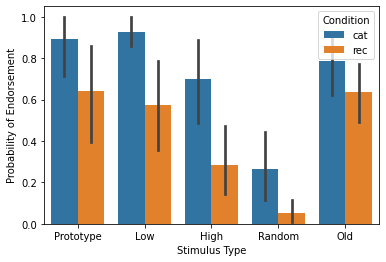

In [4]:
sns.barplot(x="Stimulus Type", y="Probability of Endorsement", hue="Condition", data=get_human_results())

<div class="alert alert-success" role="alert">
<h3> Problem 1 (20 points) </h3><br>
Using your own words explain the data pattern you see in the above figure.  What is different between the conditions and stimulus type?  Why do you suspect these patterns exist?  Your answer will need to consider the nature of the experiments, what is manipulated, and even your intuitive psychological theory about what might be going on.  Your response should take 3-4 sentences and appear in a cell below.  Is any feature of this data surprising to you?
</div>



Answer:
The two conditioning methods differ in how subjects decides to endorse the pattern as a certain stimulus type (therefore cause different P(endorsement) for each stimulus), but the actual relative probability of endorsing stimulus types follow a similar pattern for both categorization and recognition; nonetheless, Categorization has higher P(endorsement) than recognition's P(endorsement) in cases of observation. Also, there is a clear difference in P(endorsement) between the five stimulus types in that prototpye, low, and old stimulus types have higher P(endorsement) than high and random stimulus types. I suspect these patterns exist because the nature of the experiment is based on human mind's natural instinct/memory to decide whether to endorse the pattern or not; therfore, it is easier to recognize general pattern (categorization) than finding the exact match (recognition) since human memory isn't likely to be infinite. As a result, protopyte, low, and old stimulus types are able to receive high endorsement, but finding the difference between them is very difficult for human congnition (shown in the graphs). Also, what is heavily manipulated in the experiment are high and random stimulus types compared to the original train patterns shown to the subjects, which makes sense the lower endorsement in those two stimulus types. One thing that surprised me was that over half of the subjects endorsed high stimulus type, which was surprising since I expected it would be much more difficult to endorse pattern when heavy noise is introduced. 

## Predictions for the exemplar model

The following cells set up the exemplar model using the equations described above.

In [5]:
################################
# unitdist:
# computes the euclidean distance between
# two dots
################################
def unitdist(x, y):
    x1 = np.array(x)
    y1 = np.array(y)
    return math.sqrt(sum(pow(x-y, 2.0)))


################################
# computeresponse
# computes the "activation" of each
# trace in memory
################################
def computeresponse(target, memory, c, k):
    res = []
    for mem in memory:
        res.append(
            math.log(1.0+np.average(list(map(lambda x, y: unitdist(x, y), target, mem)))))
    resp = [math.exp(-c*x) for x in res]
    pofr = sum(resp)/(sum(resp)+k)
    return pofr

In [6]:
################################
# exemplar model
# stores all 10 study items in memory
# and computes the probability of endorsement
# for each item type
################################


def exemplarmodel(filename, c, k):
    data = readfile(filename)
    cond = data[-1][1]
    memory = []
    for line in data:
        if len(line) == 20 and line[1] == 2:
            memory.append(np.resize(line[2:], (9, 2)))
    # print(memory)

    # prototype items
    proto = []
    for line in data:
        if len(line) == 20 and line[1] == 1:
            item = np.resize(line[2:], (9, 2))
            pofr = computeresponse(item, memory, c, k)
            proto.append(pofr)
    # print(np.average(proto))

    # old items
    old = []
    for line in data:
        if len(line) == 20 and line[1] == 2:
            item = np.resize(line[2:], (9, 2))
            pofr = computeresponse(item, memory, c, k)
            old.append(pofr)
    # print "p of r", old
    # print(np.average(old))

    # new high items
    newhigh = []
    for line in data:
        if len(line) == 20 and line[1] == 3:
            item = np.resize(line[2:], (9, 2))
            pofr = computeresponse(item, memory, c, k)
            newhigh.append(pofr)
    # print(np.average(newhigh))

    # new low items
    newlow = []
    for line in data:
        if len(line) == 20 and line[1] == 4:
            item = np.resize(line[2:], (9, 2))
            pofr = computeresponse(item, memory, c, k)
            newlow.append(pofr)
    # print(np.average(newlow))

    # random items
    random = []
    for line in data:
        if len(line) == 20 and line[1] == 5:
            item = np.resize(line[2:], (9, 2))
            pofr = computeresponse(item, memory, c, k)
            random.append(pofr)
    # print(np.average(random))

    return [np.average(proto), np.average(newlow), np.average(newhigh), np.average(random), np.average(old), filename, cond]

In [7]:
def get_exemplar_results(c_cat, k_cat, c_rec, k_rec):
    allres = {fn: readfile(fn) for fn in get_all_filenames('data')}
    cat = []
    rec = []
    for filename in allres.keys():
        if allres[filename][-1][1] == 0:
            res = exemplarmodel(filename, c_cat, k_cat)
            cat.append(create_df(filename, 'cat', res[:-2]))
        else:
            res = exemplarmodel(filename, c_rec, k_rec)
            rec.append(create_df(filename, 'rec', res[:-2]))
    cat, rec = pd.concat(cat), pd.concat(rec)
    return pd.concat([cat, rec])

First let's replot the human results:

<AxesSubplot:xlabel='Stimulus Type', ylabel='Probability of Endorsement'>

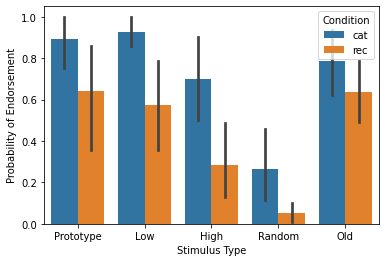

In [8]:
sns.barplot(x="Stimulus Type", y="Probability of Endorsement", hue="Condition", data=get_human_results())

<div class="alert alert-success" role="alert">
<h3> Problem 2 (10 points) </h3><br>
By hand adjust the setting of the model parameters to roughly fit the human data pattern shown above.  How close can you get?  What parameters did you find (report them) and you assessmnet of how well they fit.  Was it a good fit or are there systematic problems with the fit?  In addition, what are the parameter values and do they make sense in light of the equations described above?  When the parameters are the same for recognition and categorization instructions why do the bars look a little different?</div>

Answer:
I can get the model to roughly a similar fit to the human data pattern in terms of stimulus types, but it has lower P(endorsement) for prototype, low, and high stimulus types and Old stimulus type has much higher probability than rest of the stimulus which is different from human pattern. The parameters are {c_cat, k_cat, c_rec, k_rec = 1.7, 0.3, 1.95, 0.6}, and overall the shape of the pattern follows that of human data, but I believe the order of endorsement is different and high distortion stimulus seems too highly endorsed; therefore, I also believe there exists systematic problems with the fit. Considering the equations from above, it makes sense k value is higher for recognition condition because it is much harder to find exact match of pattern than just a general matching pattern. As mentioned above, k is the criterion that summed similarity is being compared to, so higher the k value is the less likely it is to endorse the pattern. The reason why bars are different when c_cat == c_rec and k_cat == k_rec is because of introduced random noise in the data.

The following cell lets you plot the model predictions for the exemplar model fitted to the stimuli that participants in this experiment actually viewed.  There is a $k$ and a $c$ parameter for both categorization and recogniton.

<AxesSubplot:xlabel='Stimulus Type', ylabel='Probability of Endorsement'>

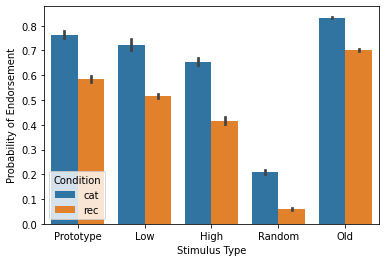

In [57]:
c_cat, k_cat, c_rec, k_rec = 1.7, 0.3, 1.95, 0.6
sns.barplot(x="Stimulus Type", y="Probability of Endorsement",
            hue="Condition", data=get_exemplar_results(c_cat, k_cat, c_rec, k_rec))

<AxesSubplot:xlabel='Stimulus Type', ylabel='Probability of Endorsement'>

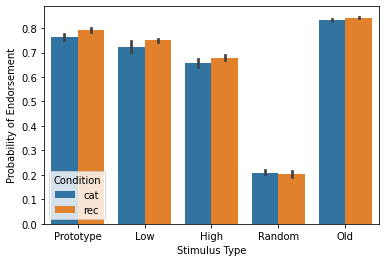

In [58]:
c_cat, k_cat, c_rec, k_rec = 1.7, 0.3, 1.7, 0.3
sns.barplot(x="Stimulus Type", y="Probability of Endorsement",
            hue="Condition", data=get_exemplar_results(c_cat, k_cat, c_rec, k_rec))

## Predictions for the prototype model

The following cells set up the prototype model using the equations described above.

In [16]:
################################
# prototype model
# stores an averate of the study items in memory
# and computes the probability of endorsement
# for each item type
################################
def prototypemodel(filename, c, k):
    data = readfile(filename)
    cond = data[-1][1]
    # average all the old items in memory
    memory = []
    for line in data:
        if len(line) == 20 and line[1] == 2:
            memory.append(line[2:])
    memory = [
        np.resize(list(map(np.average, np.transpose(np.array(memory)))), (9, 2))]

    # prototype items
    proto = []
    for line in data:
        if len(line) == 20 and line[1] == 1:
            item = np.resize(line[2:], (9, 2))
            pofr = computeresponse(item, memory, c, k)
            proto.append(pofr)
    # print(np.average(proto))

    # old items
    old = []
    for line in data:
        if len(line) == 20 and line[1] == 2:
            item = np.resize(line[2:], (9, 2))
            pofr = computeresponse(item, memory, c, k)
            old.append(pofr)
    # print "p of r", old
    # print(np.average(old))

    # new high items
    newhigh = []
    for line in data:
        if len(line) == 20 and line[1] == 3:
            item = np.resize(line[2:], (9, 2))
            pofr = computeresponse(item, memory, c, k)
            newhigh.append(pofr)
    # print(np.average(newhigh))

    # new low items
    newlow = []
    for line in data:
        if len(line) == 20 and line[1] == 4:
            item = np.resize(line[2:], (9, 2))
            pofr = computeresponse(item, memory, c, k)
            newlow.append(pofr)
    # print(np.average(newlow))

    # random items
    random = []
    for line in data:
        if len(line) == 20 and line[1] == 5:
            item = np.resize(line[2:], (9, 2))
            pofr = computeresponse(item, memory, c, k)
            random.append(pofr)
    # print(np.average(random))

    return [np.average(proto), np.average(newlow), np.average(newhigh), np.average(random), np.average(old), filename, cond]

In [17]:
def get_prototype_results(c_cat, k_cat, c_rec, k_rec):
    allres = {fn: readfile(fn) for fn in get_all_filenames('data')}
    cat = []
    rec = []
    for filename in allres.keys():
        if allres[filename][-1][1] == 0:
            res = prototypemodel(filename, c_cat, k_cat)
            cat.append(create_df(filename, 'cat', res[:-2]))
        else:
            res = prototypemodel(filename, c_rec, k_rec)
            rec.append(create_df(filename, 'rec', res[:-2]))
    cat, rec = pd.concat(cat), pd.concat(rec)
    return pd.concat([cat, rec])

Again lets replot the human results for easy reference.

<AxesSubplot:xlabel='Stimulus Type', ylabel='Probability of Endorsement'>

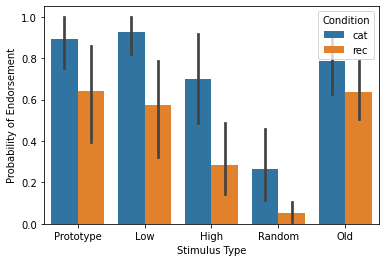

In [18]:
sns.barplot(x="Stimulus Type", y="Probability of Endorsement", hue="Condition", data=get_human_results())

<div class="alert alert-success" role="alert">
<h3> Problem 3 (10 points) </h3><br>
By hand adjust the setting of the model parameters in the next cell to roughly fit the human data pattern shown above.  How close can you get?  What parameters did you find (report them) and you assessment of how well they fit.  Was it a good fit or are there systematic problems with the fit?  In addition, what are the parameter values and do they make sense in light of the equations described above?</div>

Answer: My parameters are {c_cat, k_cat, c_rec, k_rec = 1.4, 0.06, 1.5, 0.13}. It is hard to say the model fit well and I think there are systematic problems with the fit. The endorsement probabilities made sense for prototype,low, and random stimulus, but since high and old stimulus endorsement probabilities were very similar, I didn't think it fit the human pattern precisely. Also, human data had highest endorsement for low stimulus type, different than the model below. Considering the equation above, k parameter makes sense it is higher for recognition condition because it is much harder to find exact match of pattern than finding a general matching pattern; in this note, higher k value means less endorsement.

<AxesSubplot:xlabel='Stimulus Type', ylabel='Probability of Endorsement'>

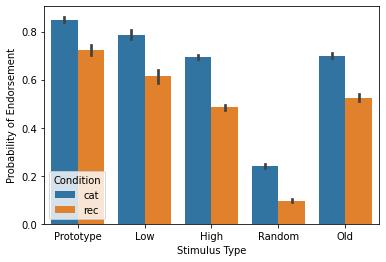

In [65]:
c_cat, k_cat, c_rec, k_rec = 1.4, 0.06, 1.5, 0.13
res=get_prototype_results(c_cat, k_cat, c_rec, k_rec)
sns.barplot(x="Stimulus Type", y="Probability of Endorsement", hue="Condition", data=res)

## Fitting the models using RMSE

Next we would like to come up with a more quantitative way to assess the quality of the model fits.  The first technique we will use is the "goodness of fit" measures that were discussed in lecture.  One of the most common measures of goodness of fit is the Root Mean Squared Error (RMSE).  This measure compares the value of each data point $x$ to each prediction $y$ using the following equation:


<br>
<center>
$\Large RMSE = \sqrt{\frac{\sum_i (x_i - y_i)^2}{N}}$
</center>
</br>

Often the RMSE is computed between the AVERAGE prediction of the model and the AVERAGE estimates of the behavior to all the subjects in an experiment.  Using the code we developed above we can find the average endorsement curves for humans and both models like this:

In [66]:
human_results=get_human_results()
exemplar_predictions = get_exemplar_results(c_cat, k_cat, c_rec, k_rec)
prototype_predictions = get_prototype_results(c_cat, k_cat, c_rec, k_rec)

In [67]:
avghuman=human_results.groupby(['Condition', 'Stimulus Type'],as_index=False).mean()
avghuman

,Condition,Stimulus Type,Probability of Endorsement
0,cat,High,0.700000
1,cat,Low,0.928571
2,cat,Old,0.785714
3,cat,Prototype,0.892857
4,cat,Random,0.264286
5,rec,High,0.285714
6,rec,Low,0.571429
7,rec,Old,0.635714
8,rec,Prototype,0.642857
9,rec,Random,0.050000


In [68]:
avgexemplar=exemplar_predictions.groupby(['Condition', 'Stimulus Type'],as_index=False).mean()
avgexemplar

,Condition,Stimulus Type,Probability of Endorsement
0,cat,High,0.939436
1,cat,Low,0.952741
2,cat,Old,0.967979
3,cat,Prototype,0.960152
4,cat,Random,0.751648
5,rec,High,0.869711
6,rec,Low,0.901237
7,rec,Old,0.933689
8,rec,Prototype,0.918836
9,rec,Random,0.505024


In [69]:
avgprototype=prototype_predictions.groupby(['Condition', 'Stimulus Type'], as_index=False).mean()
avgprototype

,Condition,Stimulus Type,Probability of Endorsement
0,cat,High,0.694033
1,cat,Low,0.786957
2,cat,Old,0.699643
3,cat,Prototype,0.849233
4,cat,Random,0.240838
5,rec,High,0.484085
6,rec,Low,0.615297
7,rec,Old,0.524251
8,rec,Prototype,0.721810
9,rec,Random,0.096520


<div class="alert alert-success" role="alert">
<h3> Problem 4 (20 points) </h3><br>
First, write a function below called `rmse` that computes the RMSE between two `numpy` vectors.  
</div>

In [70]:
def rmse(human, model):
    return np.sqrt(np.mean((human-model)**2))

Write your code above.  This code will then by used in the provided functions below to evaluate the fit of the prototype and exemplar models.  The parameters to the model is provided as a list with `[c_cat, k_cat, c_rec, k_rec]` the implied order.

In [71]:
def fit_exemplar_model_rmse(params, human_results):
    [c_cat, k_cat, c_rec, k_rec] = params
    predictions = get_exemplar_results(c_cat, k_cat, c_rec, k_rec)
    avgpredict=predictions.groupby(['Condition', 'Stimulus Type'],as_index=False).mean()
    model_results = avgpredict['Probability of Endorsement'].values
    return rmse(human_results, model_results)

def fit_prototype_model_rmse(params, human_results):
    [c_cat, k_cat, c_rec, k_rec] = params
    predictions = get_prototype_results(c_cat, k_cat, c_rec, k_rec)
    avgpredict=predictions.groupby(['Condition', 'Stimulus Type'],as_index=False).mean()
    model_results = avgpredict['Probability of Endorsement'].values
    return rmse(human_results, model_results)

In [72]:
human_results=get_human_results()
avghuman=human_results.groupby(['Condition', 'Stimulus Type'],as_index=False).mean()
human_results = avghuman['Probability of Endorsement'].values

print(fit_exemplar_model_rmse([0.1, 2.0, 0.1, 2.0], human_results))
print(fit_prototype_model_rmse([0.1, 2.0, 0.1, 2.0], human_results))

0.35330178202197526
0.3792712020204823


<div class="alert alert-success" role="alert">
Next adjust the parameters by hand for both the exemplar and prototype models to find values that appear to minimize the RMSE.  Copy the code above for plotting the predictions of the models given your best fit parameters.   Which model do you think fits better according to this fit statistic?
</div>

In [80]:
human_results=get_human_results()
avghuman=human_results.groupby(['Condition', 'Stimulus Type'],as_index=False).mean()
human_results = avghuman['Probability of Endorsement'].values

print(fit_exemplar_model_rmse([1.75, 0.2, 1.8, 0.6], human_results))
print(fit_prototype_model_rmse([1.6, 0.05, 1.5, 0.2], human_results))

0.08953586057610792
0.10145102738580922


Answer: With hand adjustment, I believe examplar model is a better fit to this fit statistic because RMSE=0.08953586057610792 for exemplar model which is lower than RMSE=0.10145102738580922 of prototype model. The overall shape of expamplar doesn't fit the human model but it does fit better than prototype when it comes to endorsement of Random and Old Stimulus types.

## Examplar by Hand

<AxesSubplot:xlabel='Stimulus Type', ylabel='Probability of Endorsement'>

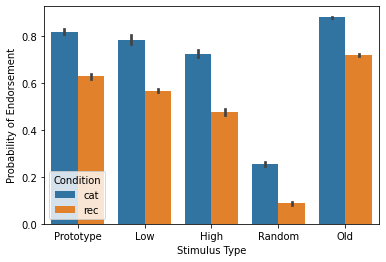

In [81]:
c_cat, k_cat, c_rec, k_rec = 1.75, 0.2, 1.8, 0.6
exemplar_results = get_exemplar_results(c_cat, k_cat, c_rec, k_rec)
sns.barplot(x="Stimulus Type", y="Probability of Endorsement", hue="Condition", data=exemplar_results)

## Prototype by Hand

<AxesSubplot:xlabel='Stimulus Type', ylabel='Probability of Endorsement'>

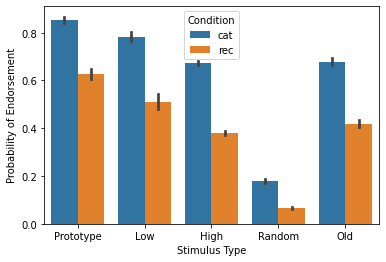

In [82]:
c_cat, k_cat, c_rec, k_rec = 1.6, 0.05, 1.5, 0.2
prototype_results = get_prototype_results(c_cat, k_cat, c_rec, k_rec)
sns.barplot(x="Stimulus Type", y="Probability of Endorsement", hue="Condition", data=prototype_results)

## Human

<AxesSubplot:xlabel='Stimulus Type', ylabel='Probability of Endorsement'>

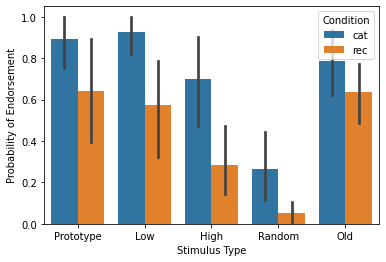

In [83]:
human_results = get_human_results()
sns.barplot(x="Stimulus Type", y="Probability of Endorsement", hue="Condition", data=human_results)

<div class="alert alert-success" role="alert">
<h3> Problem 5 (10 points) </h3><br>
Read about the scipy `fmin` function.  Use fmin to algorithmically search for the best parameters for each model using the RMSE evaluation function described above.
</div>

In [73]:
initial_x0 = [0.1, 2.0, 0.1, 2.0]

best_examplar_param = fmin(fit_exemplar_model_rmse, x0=initial_x0, args=(human_results,), full_output=True)
best_prototype_param = fmin(fit_prototype_model_rmse, x0=initial_x0, args=(human_results,), full_output=True)

print('best_examplar_param',best_examplar_param[0])
print('best_prototype_param',best_prototype_param[0])

Optimization terminated successfully.
         Current function value: 0.076819
         Iterations: 260
         Function evaluations: 435
Optimization terminated successfully.
         Current function value: 0.077796
         Iterations: 442
         Function evaluations: 743
best_examplar_param [1.73818548 0.17362409 1.92580663 0.66919728]
best_prototype_param [1.62604888 0.02939519 1.62430878 0.14084599]


In [85]:
human_results=get_human_results()
avghuman=human_results.groupby(['Condition', 'Stimulus Type'],as_index=False).mean()
human_results = avghuman['Probability of Endorsement'].values

print(fit_exemplar_model_rmse([1.73818548, 0.17362409, 1.92580663, 0.66919728], human_results))
print(fit_prototype_model_rmse([1.62604888, 0.02939519, 1.62430878, 0.14084599], human_results))

0.07681866353753997
0.07779553421390219


Here, exemplar model (RMSE=0.07681866353753997) also does slightly better than prototype model (RMSE=0.07779553421390219) in terms of RMSE.

## Examplar

<AxesSubplot:xlabel='Stimulus Type', ylabel='Probability of Endorsement'>

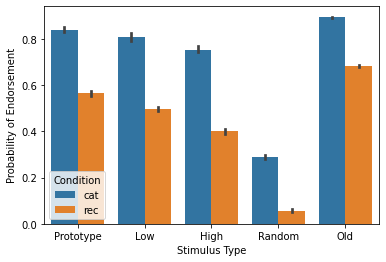

In [86]:
c_cat, k_cat, c_rec, k_rec = 1.73818548, 0.17362409, 1.92580663, 0.66919728
exemplar_results = get_exemplar_results(c_cat, k_cat, c_rec, k_rec)
sns.barplot(x="Stimulus Type", y="Probability of Endorsement", hue="Condition", data=exemplar_results)

## Prototype

<AxesSubplot:xlabel='Stimulus Type', ylabel='Probability of Endorsement'>

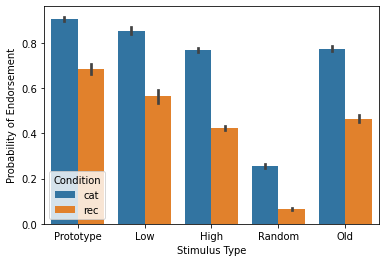

In [87]:
c_cat, k_cat, c_rec, k_rec = 1.62604888, 0.02939519, 1.62430878, 0.14084599
prototype_results = get_prototype_results(c_cat, k_cat, c_rec, k_rec)
sns.barplot(x="Stimulus Type", y="Probability of Endorsement", hue="Condition", data=prototype_results)